# 03.5 Stochastic Differential Equations (SDEs) and Numerical Schemes
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**
- Introduce SDEs of the form
    $$dX_t = b(t, X_t)\, dt + \sigma(t, X_t)\, dW_t$$
- Recall the existence–uniqueness theorem (Lipschitz + linear growth).
- Present the Euler–Maruyama scheme and its strong convergence of order $1/2$.
- Compare numerical schemes to exact solutions on Ornstein–Uhlenbeck (OU) and GBM.
- Visualise errors vs time step size.
- Implement Monte Carlo pricing of a European call under GBM (risk-neutral).

**This notebook**

Develops the numerical side of stochastic differential equations. We implement and study the Euler–Maruyama scheme, compare numerical paths to exact solutions (OU and GBM), analyse strong convergence, and perform a full Monte Carlo case study for a European call under geometric Brownian motion.


# 1. General SDE framework

We introduce the general form of a stochastic differential equation. This sets the theoretical ground for numerical methods, since all schemes rely on the drift 𝑏 and volatility 𝜎 functions of an SDE.

We consider an SDE on $[0,T]$ of the form:

$$dX_t = b(t,X_t)\,dt + \sigma(t,X_t)\,dW_t, \quad X_0 = x_0.$$

The coefficients satisfy:

**Lipschitz condition**

$$|b(t,x) - b(t,y)| + |\sigma(t,x) - \sigma(t,y)| \leq L|x - y|$$

**Linear growth**

$$|b(t,x)| + |\sigma(t,x)| \leq C(1 + |x|)$$

**Theorem (existence & uniqueness).**  
Under the above conditions, the SDE admits a unique strong solution.

This ensures that the Euler–Maruyama scheme converges as the time step goes to zero.


# 2. Euler–Maruyama scheme

The fundamental numerical method for simulating SDEs. It provides a first-order discretisation of the dynamics and forms the benchmark for all other schemes.

For a partition $0 = t_0 < t_1 < \cdots < t_n = T$ with step $dt$, the scheme is:

$$X_{k+1} = X_k + b(t_k, X_k) \, dt + \sigma(t_k, X_k) \, \Delta W_k, \quad \Delta W_k \sim \mathcal{N}(0, dt).$$

**Strong convergence rate:** $O(dt^{1/2})$.

**Weak convergence rate:** $O(dt)$.

We implement a generic function.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["axes.grid"] = True

In [5]:
def euler_maruyama(b, sigma, x0, T, n_steps, rng):
    dt = T / n_steps
    t = np.linspace(0, T, n_steps+1)
    X = np.zeros(n_steps+1)
    X[0] = x0
    dW = rng.normal(0.0, np.sqrt(dt), size=n_steps)
    for k in range(n_steps):
        X[k+1] = X[k] + b(t[k], X[k])*dt + sigma(t[k], X[k])*dW[k]
    return t, X

# 3. Ornstein–Uhlenbeck (OU) process

The OU process is the canonical mean-reverting diffusion. It admits a closed-form solution, which makes it ideal for validating numerical schemes and checking convergence.

The OU SDE is:

$$dX_t = -c X_t \, dt + \sigma \, dW_t$$

**Exact solution:**

$$X_t = x_0 e^{-ct} + \sigma e^{-ct} \int_0^t e^{cs} \, dW_s$$

**Moments:**

$$\mathbb{E}[X_t] = x_0 e^{-ct}, \quad \text{Var}(X_t) = \frac{\sigma^2}{2c}(1 - e^{-2ct})$$

We compare Euler–Maruyama paths with the exact solution.


In [6]:
# OU parameters
c = 2.0
sigma_OU = 1.0
x0 = 1.0
T = 1.0
n_steps = 1000

def OU_exact(t, x0, c, sigma, W):
    # exact formula using simulated W_t
    return x0*np.exp(-c*t) + sigma*np.exp(-c*t)*(np.exp(c*t)*W)

# simulate Brownian path
dt = T/n_steps
t_grid = np.linspace(0,T,n_steps+1)
dW = rng.normal(0.0, np.sqrt(dt), size=n_steps)
W = np.concatenate(([0.0], np.cumsum(dW)))

# Euler scheme
b = lambda t,x: -c*x
sig = lambda t,x: sigma_OU
t_E, X_E = euler_maruyama(b, sig, x0, T, n_steps, rng)

# exact OU solution for the same Brownian path
X_exact = x0*np.exp(-c*t_grid) + sigma_OU*np.exp(-c*t_grid)*(np.exp(c*t_grid)*W)

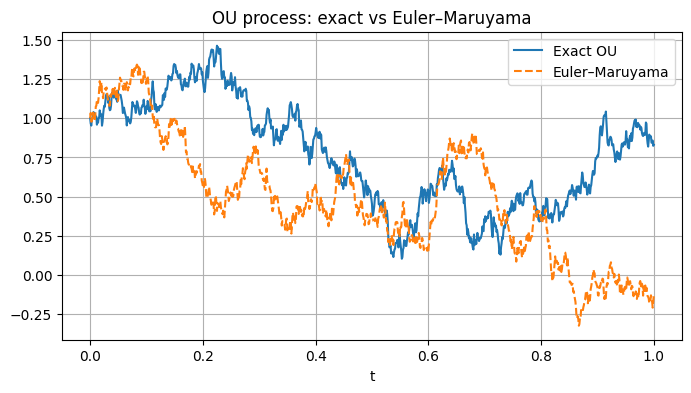

In [7]:
plt.plot(t_grid, X_exact, label="Exact OU")
plt.plot(t_E, X_E, '--', label="Euler–Maruyama")
plt.title("OU process: exact vs Euler–Maruyama")
plt.xlabel("t")
plt.legend()
plt.show()

The Euler–Maruyama path captures the overall mean-reversion of the exact OU process but deviates progressively and appears rougher. These visible discrepancies come from time-step discretisation and will shrink as we refine the grid—exactly what the next section quantifies through the strong error analysis.

# 4. Strong error vs time step size (OU)

We quantify the numerical error of Euler–Maruyama by comparing the approximate solution at time $T$ with the exact one. This reveals the classical strong convergence rate of order $1/2$.

We compute $\mathbb{E}|X_T - X_T^{(E)}|$ for decreasing $dt$.


In [ ]:
def strong_error_OU(n_steps, n_paths=2000):
    errors = []
    for _ in range(n_paths):
        dt = T/n_steps
        # simulate Brownian increments
        dW = rng.normal(0.0, np.sqrt(dt), size=n_steps)
        W = np.concatenate(([0.0], np.cumsum(dW)))
        t_grid = np.linspace(0,T,n_steps+1)

        # exact solution
        X_ex = x0*np.exp(-c*t_grid[-1]) \
               + sigma_OU*np.exp(-c*t_grid[-1])*(np.exp(c*t_grid[-1])*W[-1])

        # Euler scheme
        X_e = x0
        for k in range(n_steps):
            X_e += -c*X_e*dt + sigma_OU*dW[k]

        errors.append(abs(X_ex - X_e))
    return np.mean(errors)

tests = [20, 40, 80, 160, 320, 640]
err_vals = [strong_error_OU(n) for n in tests]

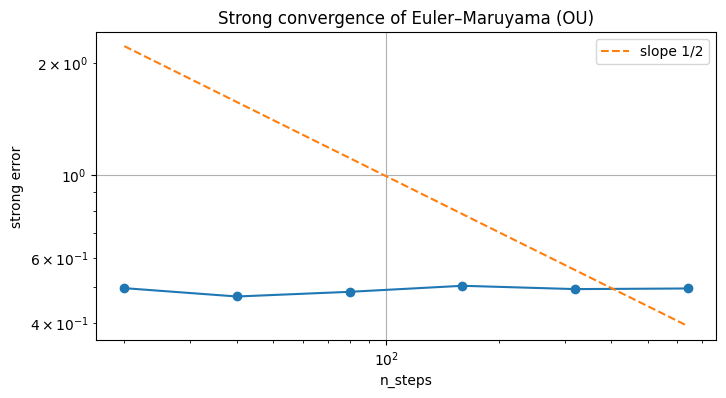

In [ ]:
plt.loglog(tests, err_vals, marker="o")
plt.loglog(tests, tests[0]/np.array(tests)**0.5 * err_vals[0], '--', 
           label="slope 1/2")
plt.xlabel("n_steps")
plt.ylabel("strong error")
plt.title("Strong convergence of Euler–Maruyama (OU)")
plt.legend()
plt.show()

The plot shows that the strong error decreases with the expected order 1/2. Euler–Maruyama exhibits the classical strong convergence rate: refining the time step reduces the pathwise error at the predicted square-root speed.

# 5. Geometric Brownian Motion (GBM)

GBM is the standard model for asset prices. It has an exact solution and a lognormal distribution, allowing a direct comparison with Euler–Maruyama on a financially relevant example.

The GBM SDE is:

$$dS_t = \mu S_t \, dt + \sigma S_t \, dW_t.$$

**Exact solution:**

$$S_t = S_0 \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right).$$

We compare Euler–Maruyama with the exact solution.


In [21]:
S0 = 1.0
mu = 0.3
sigma_GBM = 0.5
T = 1.0
n_steps = 1000

# simulate one Brownian path
dt = T/n_steps
t_grid = np.linspace(0,T,n_steps+1)
dW = rng.normal(0.0,np.sqrt(dt),size=n_steps)
W = np.concatenate(([0.0], np.cumsum(dW)))

# Euler GBM
S = np.zeros(n_steps+1)
S[0] = S0
for k in range(n_steps):
    S[k+1] = S[k] + mu*S[k]*dt + sigma_GBM*S[k]*dW[k]

# exact GBM
S_exact = S0 * np.exp((mu - 0.5*sigma_GBM**2)*t_grid + sigma_GBM*W)

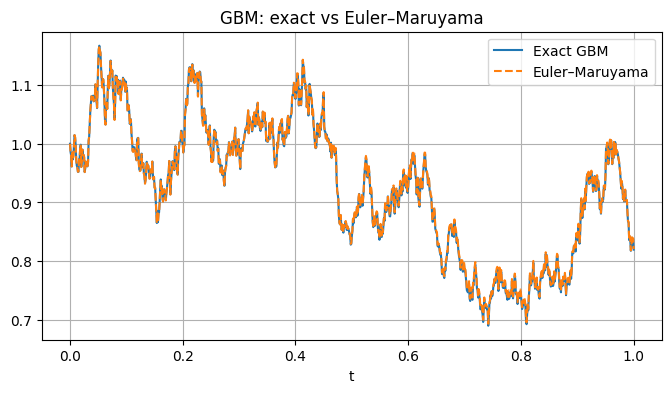

In [22]:
plt.plot(t_grid, S_exact, label="Exact GBM")
plt.plot(t_grid, S, '--', label="Euler–Maruyama")
plt.title("GBM: exact vs Euler–Maruyama")
plt.xlabel("t")
plt.legend()
plt.show()

The Euler–Maruyama path tracks the exact GBM almost perfectly. Because GBM is linear in the Brownian increment, the discretisation error is very small, and the two trajectories are nearly indistinguishable at this step size.

# 6. Monte Carlo pricing of a European call under GBM

We apply the GBM dynamics to price a European call option under the risk-neutral measure. This illustrates how SDE simulation connects directly to quantitative finance.

Under the risk-neutral measure:

$$dS_t = rS_t \, dt + \sigma S_t \, dW_t$$

The payoff of a call is $(S_T - K)^+$.

Exact solution for $S_T$ is lognormal.

Monte Carlo estimator:

$$C_0^{MC} = e^{-rT} \frac{1}{M}\sum_{i=1}^M (S_T^{(i)} - K)^+$$


In [ ]:
def mc_call_price(S0, K, r, sigma, T, n_paths=200000):
    Z = rng.normal(size=n_paths)
    ST = S0*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r*T)*payoff.mean(), payoff.std(ddof=1)/np.sqrt(n_paths)

S0 = 1.0
K = 1.0
r = 0.02
sigma = 0.3
T = 1.0

price, se = mc_call_price(S0,K,r,sigma,T)
price, se

(np.float64(0.12791358727878668), np.float64(0.0004927080866148972))

The Monte-Carlo estimator gives a call price around 0.128, with a very small standard error (≈ 5×10⁻⁴), indicating a stable numerical estimate. We can compare it to the Black–Scholes closed-form once needed.